<a href="https://colab.research.google.com/github/castielle/client/blob/master/Notebook_3_Thai_Multi_class_Classification_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install -U pytorch-lightning tensorboard transformers pythainlp

# Imports

In [2]:
from collections import Counter, defaultdict
from itertools import chain
from pprint import pprint
from typing import Dict, List, NamedTuple, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn.functional as F
from pytorch_lightning.core.decorators import auto_move_data
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold, ShuffleSplit
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from imblearn.over_sampling import SMOTE
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm.notebook import tqdm
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BatchEncoding,
    default_data_collator,
)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
EPSILON = 1e-12

# Data Processing

In [5]:
DATA_PATH = "/gdrive/My Drive/Colab/Thai/corpus-up.csv"

In [6]:
from pythainlp.util import normalize
from pythainlp import word_tokenize

df = pd.read_csv(DATA_PATH, index_col=0)
tokenized = df['tokenized']

corpus = []
for line in tqdm(tokenized, total=len(tokenized)):
    x = eval(line)
    newline = ' '.join(i for i in x).strip()
    newline = normalize(newline)
    newline = ' '.join(word_tokenize(newline))
    corpus.append(newline)
df['corpus'] = corpus

In [7]:
# Merge `n` and `p` in to `n + p`
df["n + p"] = (df["n"].notna() | df["p"].notna()).astype(float).replace(0, np.nan)

In [8]:
LABELS = ["r", "f", "o", "d", "n + p"]

In [ ]:
def assign_label(row):
    for i in LABELS:
        if pd.notna(row[i]):
            return i
    return ""

In [ ]:
def balance(X, y):
    label_counts = y.value_counts().to_dict()
    max_value = max(label_counts.values())
    balanced = []
    for label, label_count in label_counts.items():
        label_items = X[y == label]
        num_label_items = len(label_items)
        duplications = max_value // num_label_items
        items = pd.concat([label_items for _ in range(duplications)])
        balanced.append(items)
    return pd.concat(balanced)

In [ ]:
def subsample(X, y):
    label_counts = y.value_counts().to_dict()
    min_value = min(label_counts.values())
    balanced = []
    for label, label_count in label_counts.items():
        label_items = X[y == label]
        items = label_items.sample(n=min_value)
        balanced.append(items)
    return pd.concat(balanced)

In [ ]:
y = df.apply(assign_label, axis=1)

In [ ]:
[y.value_counts()[i] for i in LABELS]

[5617, 753, 257, 143, 19339]

In [ ]:
class_weights = torch.softmax(torch.tensor([len(y) / y.value_counts()[i] for i in LABELS]).clip(0, 10), 0).float().cuda()
class_weights = torch.tensor([1/50, 1/8, 1/2, 1/3, 1/140]).float().cuda()
class_weights

tensor([0.0200, 0.1250, 0.5000, 0.3333, 0.0071], device='cuda:0')

In [ ]:
[y.value_counts()[i] * class_weights[j] for j, i in enumerate(LABELS)]

[tensor(112.3400, device='cuda:0'),
 tensor(94.1250, device='cuda:0'),
 tensor(128.5000, device='cuda:0'),
 tensor(47.6667, device='cuda:0'),
 tensor(138.1357, device='cuda:0')]

In [ ]:
df[pd.isna(df["n + p"])]

,text,r,f,o,d,n,p,tokenized,corpus,n + p
0,สภาพเดินซัก1กิโลให้ได้ก่อน,NaN,NaN,x,NaN,NaN,NaN,"['สภาพ', 'เดิน', 'ซัก', '1กิโล', 'ให้', 'ได้',...",สภาพ เดิน ซัก 1 กิโล ให้ ได้ ก่อน,NaN
1,ไปลดน้ำหนักไปปปปป,NaN,NaN,x,NaN,NaN,NaN,"['ไป', 'ลด', 'น้ำหนัก', 'ไป', 'ปปปป']",ไป ลด น้ำหนัก ไป ปปปป,NaN
2,กูแตก,NaN,NaN,NaN,NaN,NaN,NaN,"['กู', 'แตก']",กู แตก,NaN
3,อุลตร้าแมนแจ็คกู55555(ใช่รึป่าววะไม่ได้ดูนานละ),x,NaN,NaN,NaN,NaN,NaN,"['อุลตร้าแมนแจ็คกู', '55555', '(', 'ใช่', 'รึ'...",อุลตร้าแมน แจ็ค กู 55555 ( ใช่ รึ ป่...,NaN
4,ไปลดนํ้าหนักก่อนดีมั้ยอ่ะ,NaN,NaN,x,NaN,NaN,NaN,"['ไปล', 'ดน', 'ํ้า', 'หนัก', 'ก่อน', 'ดี', 'มั...",ไป ล ดน ้ำ หนัก ก่อน ดี มั้ย อ่ะ,NaN
...,...,...,...,...,...,...,...,...,...,...
11626,จิตใจเลวมาก เหี้ยสุด\n,NaN,x,NaN,NaN,NaN,NaN,"['จิตใจ', 'เลว', 'มาก', ' ', 'เหี้ย', 'สุด', '...",จิตใจ เลว มาก เหี้ย สุด,NaN
11627,เเค่เห็นคลิปชี้หน้าผากเด็กเเค่นั้นฉันยังหดหู่เ...,x,x,x,NaN,NaN,NaN,"['เเค่', 'เห็น', 'คลิป', 'ชี้', 'หน้าผาก', 'เด...",แค่ เห็น คลิป ชี้ หน้าผาก เด็ก แค่ ...,NaN
11628,แบบนี้ไม่ใช่ รร เป็นนรกชัดๆ,NaN,NaN,x,NaN,NaN,NaN,"['แบบ', 'นี้', 'ไม่', 'ใช่', ' ', 'รร', ' ', '...",แบบ นี้ ไม่ ใช่ รร เป็น นรก ชัด ๆ,NaN
11629,จริง แบบนี้มันเหี้ย เหี้ยชัดๆ ไม่มีความเป็นคนแ...,NaN,x,NaN,NaN,NaN,NaN,"['จริง', ' ', 'แบบ', 'นี้', 'มัน', 'เหี้ย', ' ...",จริง แบบ นี้ มัน เหี้ย เหี้ย ชัด ๆ...,NaN


In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(corpus)

df_train_original, df_valid_original = train_test_split(
    df, train_size=0.75, random_state=42
)

FOLDS = 2

# Helpers

In [ ]:
def process_train(df_train: pd.DataFrame):
    xs, ys = [], []
    for _, row in tqdm(df_train.iterrows(), total=len(df_train)):
        for label in LABELS:
            if not pd.isna(row[label]):
                xs.append(row["corpus"])
                ys.append(label)
    return xs, ys

X_train, y_train = process_train(df_train_original)

In [ ]:
def process_test(df_valid: pd.DataFrame):
    xs, ys = [], []
    for _, row in tqdm(df_valid.iterrows(), total=len(df_valid)):
        possible_labels = []
        for label in LABELS:
            if not pd.isna(row[label]):
                possible_labels.append(label)
        if possible_labels:
            xs.append(row["corpus"])
            ys.append(possible_labels)
    return xs, ys

X_valid, y_valid = process_test(df_valid_original)

In [ ]:
model_benchmarks = {} # model scores
C = {} # confusion matrices

### Plotting

In [ ]:
class Metrics(NamedTuple):
    prec: float
    recall: float
    f1: float
    support: int

def get_tp_fp_fn(y_true: List[List[str]], y_pred: List[str]):
    tps, fps, fns = defaultdict(int), defaultdict(int), defaultdict(int)
    for t, p in zip(y_true, y_pred):
        if p in t:
            # True positive
            for i in t:
                tps[i] += 1
        else:
            # False positive for pred
            fps[p] += 1
            # False negative for true
            for i in t:
                fns[i] += 1
    return tps, fps, fns

def get_prec_recall_f1_support(y_true: List[List[str]], y_pred: List[str]):
    tps, fps, fns = get_tp_fp_fn(y_true, y_pred)
    tp = sum(list(tps.values()))
    fp = sum(list(fps.values()))
    fn = sum(list(fns.values()))
    prec = tp / (tp + fp + EPSILON)
    recall = tp / (tp + fn + EPSILON)
    f1 = 2 * (prec * recall) / (prec + recall + EPSILON)
    support = tp + fn
    return Metrics(prec, recall, f1, support)

def get_cm(y_true: List[List[str]], y_pred: List[str]):
    tps, fps, fns = get_tp_fp_fn(y_true, y_pred)
    cm = np.zeros((len(LABELS), len(LABELS)), dtype=np.int)
    def L(i: str) -> str: return LABELS.index(i)
    for t, p in zip(y_true, y_pred):
        if p in t:
            # True positive
            for i in t:
                cm[L(i)][L(i)] += 1
        else:
            for i in t:
                cm[L(i)][L(p)] += 1
    return cm

def plot_cm(cm, label: str, normalize: bool = True):
    C = cm if not normalize else cm / (cm.sum(1)[:, None] + EPSILON)
    fmt = ".1%" if normalize else "d"
    vmin = 0 if normalize else cm.min()
    vmax = 1 if normalize else cm.max()
    plt.figure(figsize = (10,7))
    plt.title(label if not normalize else f"{label} (Normalized)")
    plt.tick_params(labelbottom=False, bottom=False, top=False, labeltop=True)
    sns.heatmap(pd.DataFrame(C, index=LABELS, columns=LABELS), annot=True, fmt=fmt, cmap="Purples", vmin=vmin, vmax=vmax)

def plot_benchmarks():
    pd.DataFrame(model_benchmarks, index=["value"]).T.plot(grid=True, figsize=(20, 10))
    plt.xticks(rotation=20)

def plot_cms(normalize: bool = True):
    for k, v in C.items():
        plot_cm(v, label=k, normalize=normalize)

In [ ]:
class EvalResult(NamedTuple):
    model_name: str
    precision: float
    recall: float
    f1_score: float
    confusion_matrix: np.ndarray

# Scikit-Learn Models

In [ ]:
def train_model(model, train, test) -> EvalResult:
    model_name = str(model).split('(')[0]
    print(f"Training {model_name}")
    X_train, y_train = process_train(train)
    X_valid, y_valid = process_test(test)

    model.fit(vectorizer.transform(X_train), y_train)
    pred = model.predict(vectorizer.transform(X_valid))
    precision, recall, f1_score, _ = get_prec_recall_f1_support(y_true=y_valid, y_pred=pred)
    confusion_matrix = get_cm(y_valid, pred)
    return EvalResult(model_name, precision, recall, f1_score, confusion_matrix)

In [ ]:
models = [SGDClassifier(), MultinomialNB(), BernoulliNB()]

In [ ]:
for model in tqdm(models):
    kf = StratifiedKFold(n_splits=FOLDS)
    f_scores = []
    model_results = []
    for train, test in kf.split(df, y=y):
        df_train = df.iloc[train]
        df_test = df.iloc[test]
        result = train_model(model, df_train, df_test)
        f_scores.append(result.f1_score)
        model_results.append(result)
    
    best_result_index = np.argmax(f_scores)
    best_result = model_results[best_result_index]
    model_benchmarks[best_result.model_name] = best_result.f1_score
    C[best_result.model_name] = best_result.confusion_matrix

Training SGDClassifier



Training SGDClassifier



Training MultinomialNB



Training MultinomialNB



Training BernoulliNB



Training BernoulliNB


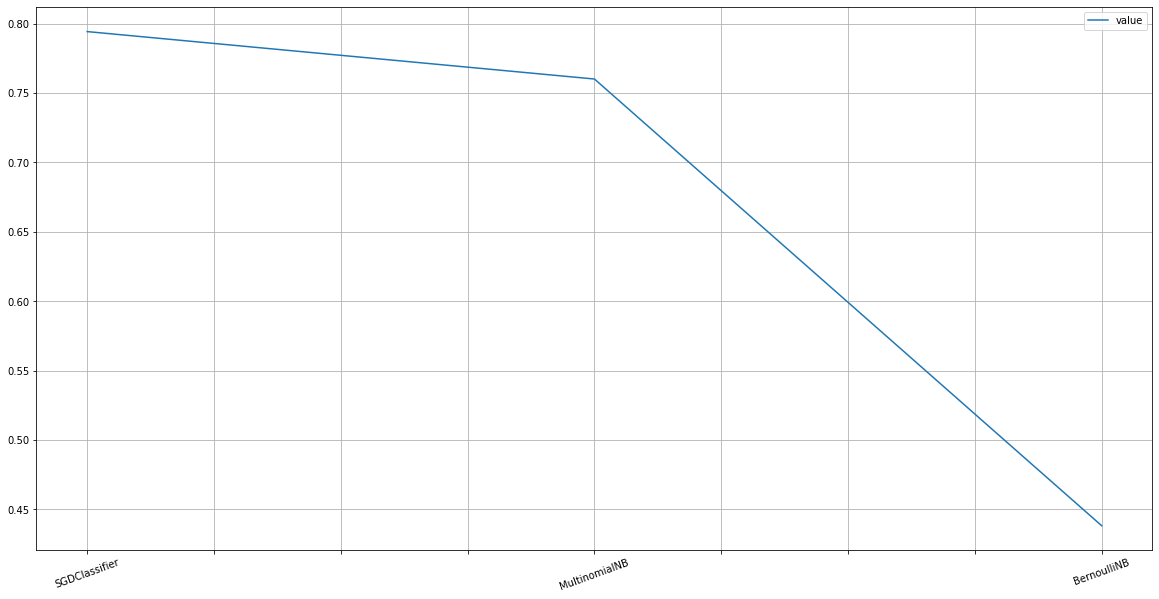

In [ ]:
plot_benchmarks()

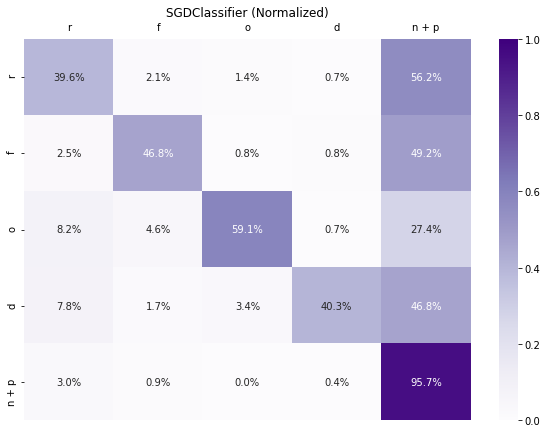

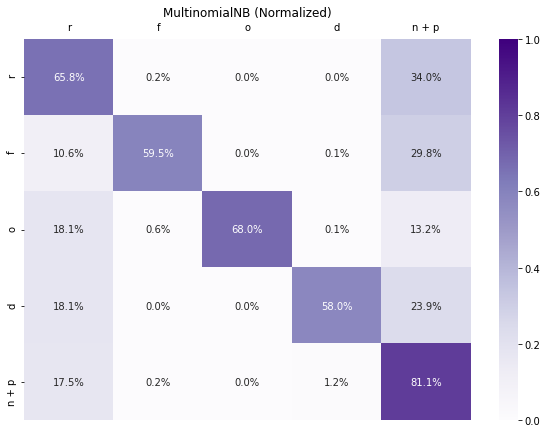

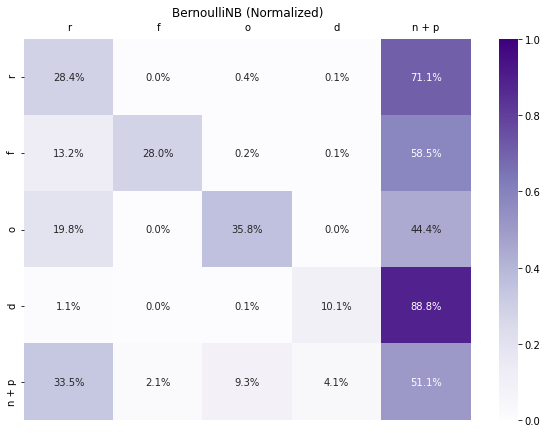

In [ ]:
plot_cms(normalize=True)

In [ ]:
from pythainlp import subword_tokenize

all_words = []
for i in corpus: all_words.extend(word_tokenize(normalize(i)))
count_words = Counter(all_words)
total_words = len(all_words)
sorted_words = count_words.most_common(total_words)
print(f"Top ten occuring words: {sorted_words[:10]}")

Top ten occuring words: [(' ', 687007), ('ไม่', 11880), ('ที่', 10437), ('#', 9131), ('.', 8295), ('ได้', 8210), ('ไป', 7840), ('มา', 7076), ('มี', 7005), ('นี้', 6248)]


In [ ]:
vocab_to_int = {w: i + 1 for i, (w, c) in enumerate(sorted_words)}

# LSTM

In [ ]:
class Example(NamedTuple):
    text: List[int]
    label: int

## Parameters

In [ ]:
MAX_LENGTH = 80
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
LEARNING_RATE = 5e-3

VOCAB_SIZE = len(vocab_to_int) + 1
NUM_LABELS = len(LABELS)
EMBEDDING_DIM = 50
HIDDEN_DIM = 64
NUM_LAYERS = 4
EPOCHS = 5
DROPOUT = 0.3

## Data Module

In [ ]:
class DataModule(pl.LightningDataModule):
    def __init__(self, train, test,
                 train_batch_size: int,
                 test_batch_size: int):
        super().__init__()
        X_train, y_train = process_train(train)
        print(Counter(y_train))
        X_valid, y_valid = process_test(test)
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        features: Dict[str, List[Example]] = {}
        features["train"] = self._featurize(X_train, y_train)
        features["valid"] = self._featurize(X_valid, y_valid)
        xtr = torch.tensor([i.text for i in features["train"]], dtype=torch.long)
        ytr = torch.tensor([i.label for i in features["train"]], dtype=torch.long)
        xval = torch.tensor([i.text for i in features["valid"]], dtype=torch.long)

        self.train_data = TensorDataset(xtr, ytr)
        self.valid_data = TensorDataset(xval)
    
    @classmethod
    def _featurize(cls, X, Y):
        features = []
        for x, y in zip(tqdm(X), Y):
            row_text = x
            label = y
            input_features: List[int] = []

            for word in word_tokenize(normalize(row_text)):
                if word not in vocab_to_int.keys():
                # if word is not available in vocab_to_int put 0 in that place
                    input_features.append(0)
                else:
                    input_features.append(vocab_to_int[word])

            seq_len = len(input_features)

            if (seq_len <= MAX_LENGTH):
                zeros= [0] * (MAX_LENGTH - seq_len)
                new = zeros + input_features
            else:
                new = input_features[:MAX_LENGTH]
            
            if isinstance(label, str): # train
                features.append(Example(new, LABELS.index(label)))
            else: # validation, labels are lists
                features.append(Example(new, label))
        return features

    def train_dataloader(self):
        return DataLoader(self.train_data, shuffle=True, batch_size=self.train_batch_size, num_workers=4)
    def val_dataloader(self):
        return DataLoader(self.valid_data, shuffle=False, batch_size=self.test_batch_size, num_workers=4)
    def test_dataloader(self):
        return DataLoader(self.valid_data, shuffle=False, batch_size=self.test_batch_size, num_workers=4)

## LSTM Module

In [ ]:
class LSTMClassifier(pl.LightningModule):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True, bidirectional=True)
        
        self.dropout = nn.Dropout(DROPOUT)
        
        self.fc = nn.Linear(hidden_dim * 2, output_size)        

    def forward(self, x):
        embeds = self.embedding(x)
        x, _ = self.lstm(embeds)
        out = self.dropout(x[:, -1, :])
        logits = self.fc(out)
        return logits.squeeze()
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=LEARNING_RATE)
    
    def training_step(self, batch, batch_index):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y, weight=class_weights)
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        x, = batch
        logits = self(x)
        preds = torch.argmax(logits, axis=-1)
        return {"preds": preds}
    
    def predict(self, dm: pl.LightningDataModule):
        preds = []
        for i, batch in enumerate(dm.test_dataloader()):
            out = self.validation_step(batch, i)
            preds.extend(out["preds"].cpu().numpy().tolist())
        return preds, y_valid

    def validation_epoch_end(self, outputs):
        preds = torch.cat([x["preds"] for x in outputs]).squeeze().cpu().numpy().tolist()
        preds = [LABELS[i] for i in preds]
        labels = y_valid
        precision, recall, f1, _ = get_prec_recall_f1_support(y_true=labels, y_pred=preds)
        self.log_dict({"precision": precision, "recall": recall, "f1": f1}, prog_bar=True)

## Train

In [ ]:
def train_lstm(train, test) -> EvalResult:
    dm = DataModule(train, test, train_batch_size=TRAIN_BATCH_SIZE, test_batch_size=TEST_BATCH_SIZE)
    model_name = "LSTM"

    print(f"Training {model_name}")

    model = LSTMClassifier(VOCAB_SIZE, NUM_LABELS, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
    trainer = pl.Trainer(max_epochs=EPOCHS, gpus=1, checkpoint_callback=False, gradient_clip_val=0.5)
    trainer.fit(model, dm)
    model.eval()
    with torch.no_grad():
        pred, labels = model.predict(dm)
    pred = [LABELS[i] for i in pred]
    precision, recall, f1_score, _ = get_prec_recall_f1_support(y_true=labels, y_pred=pred)
    confusion_matrix = get_cm(labels, pred)
    return EvalResult(model_name, precision, recall, f1_score, confusion_matrix)

In [ ]:
y.value_counts()

n + p    19339
r         5617
          4861
f          753
o          257
d          143
dtype: int64


Counter({'n + p': 9670, 'r': 2808, 'd': 1272, 'f': 1075, 'o': 505})


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 1.3 M 
1 | lstm      | LSTM      | 357 K 
2 | dropout   | Dropout   | 0     
3 | fc        | Linear    | 645   
----------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params



Training LSTM



Counter({'n + p': 9669, 'r': 2809, 'f': 1586, 'o': 719, 'd': 293})


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 1.3 M 
1 | lstm      | LSTM      | 357 K 
2 | dropout   | Dropout   | 0     
3 | fc        | Linear    | 645   
----------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params



Training LSTM


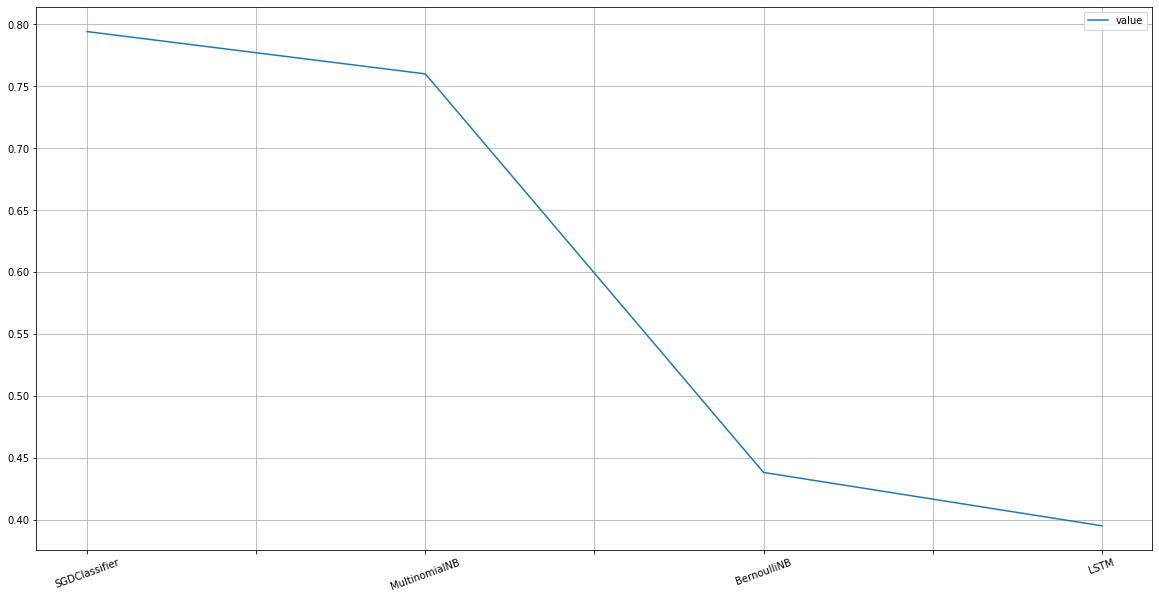

In [ ]:
kf = StratifiedKFold(n_splits=FOLDS)
f_scores = []
model_results = []
for train, test in kf.split(df, y=y):
    df_train = df.iloc[train]
    df_test = df.iloc[test]
    result = train_lstm(df_train, df_test)
    f_scores.append(result.f1_score)
    model_results.append(result)

best_result_index = np.argmax(f_scores)
best_result = model_results[best_result_index]
model_benchmarks[best_result.model_name] = best_result.f1_score
C[best_result.model_name] = best_result.confusion_matrix

plot_benchmarks()

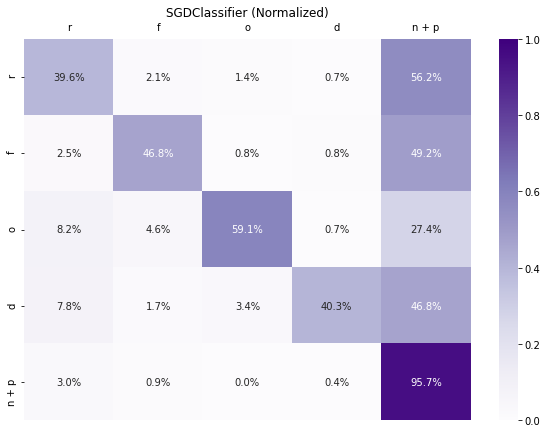

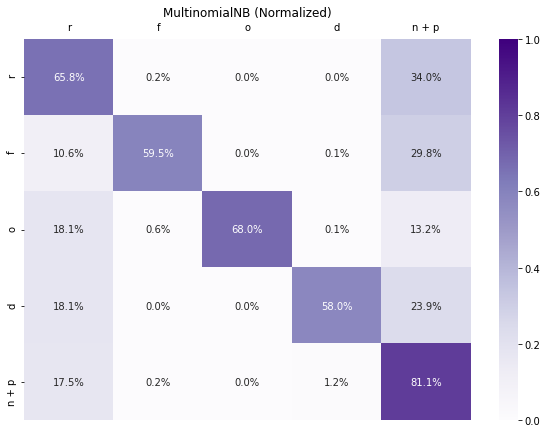

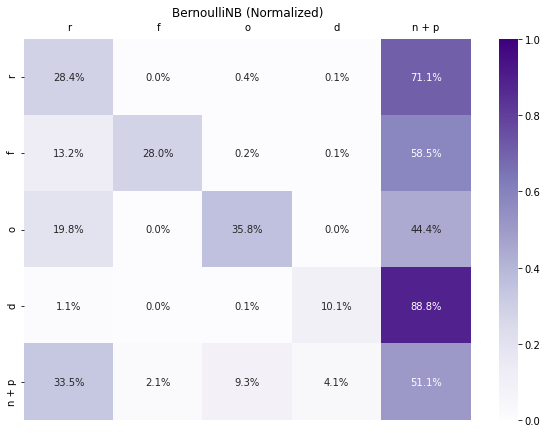

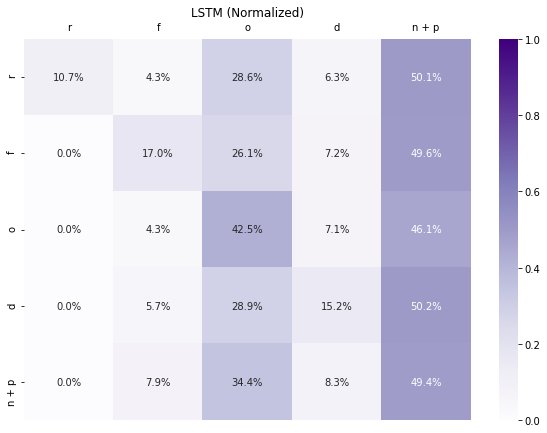

In [ ]:
plot_cms()

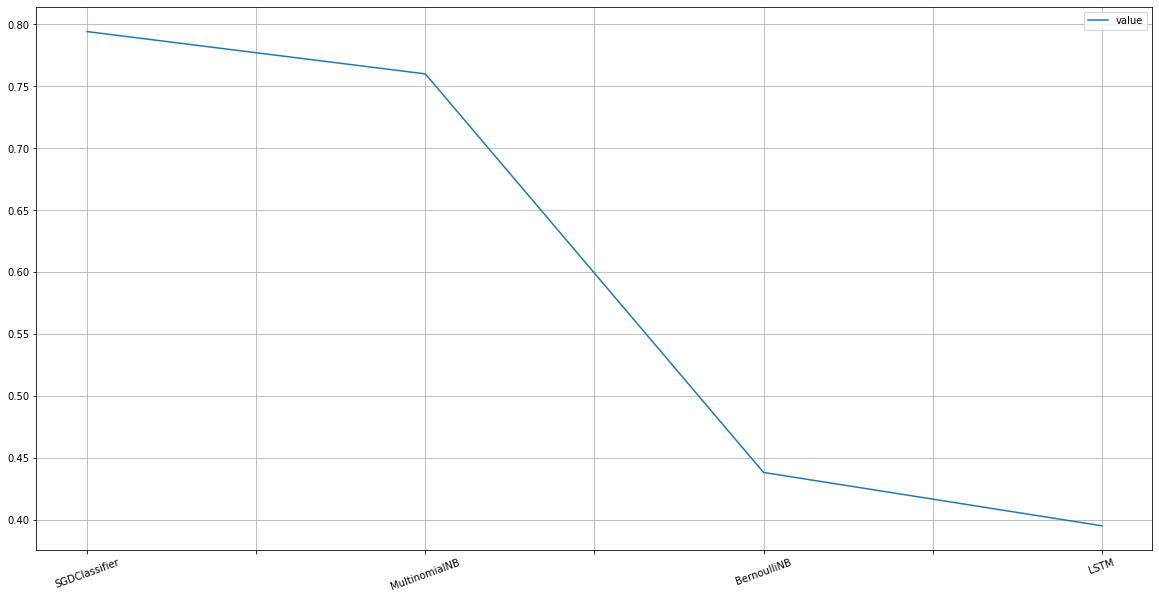

In [ ]:
plot_benchmarks()

# Transformers

## Parameters

In [ ]:
MAX_LENGTH = 80
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 64
LEARNING_RATE = 5e-5
EPOCHS = 1

MODEL_NAME = "distilbert-base-multilingual-cased"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

## Dataset

In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, items):
        self.items = items
    def __len__(self):
        return len(self.items)
    def __getitem__(self, index):
        return self.items[index]

## Data Module

In [ ]:
def tokenize(text: str) -> BatchEncoding:
    encoding = tokenizer(text, return_tensors="pt", padding="max_length", max_length=MAX_LENGTH, truncation=True)
    for k in list(encoding.keys()):
        encoding[k] = encoding[k].squeeze()
    return encoding

In [ ]:
class TransformerDataModule(pl.LightningDataModule):
    def __init__(self, train, test,
                 train_batch_size: int,
                 test_batch_size: int):
        super().__init__()
        X_train, y_train = process_train(train)
        X_valid, y_valid = process_test(test)
        
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        features: Dict[str, List[BatchEncoding]] = defaultdict(list)
        for x, y in zip(X_train, y_train):
            encoding = tokenize(normalize(x))
            encoding["labels"] = LABELS.index(y)
            features["train"].append(encoding)
        
        for x in X_valid:
            encoding = tokenize(normalize(x))
            features["valid"].append(encoding)

        self.train_data = SimpleDataset(features["train"])
        self.valid_data = SimpleDataset(features["valid"])

    def train_dataloader(self):
        return DataLoader(self.train_data, shuffle=True, batch_size=self.train_batch_size, num_workers=4)
    def val_dataloader(self):
        return DataLoader(self.valid_data, shuffle=False, batch_size=self.test_batch_size, num_workers=4)
    def test_dataloader(self):
        return DataLoader(self.valid_data, shuffle=False, batch_size=self.test_batch_size, num_workers=4)

## Transformer Module

In [ ]:
class TransformerClassifier(pl.LightningModule):
    def __init__(self, num_labels: int):
        super().__init__()
        self.config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=num_labels)
        self.model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=self.config)     

    @auto_move_data
    def forward(self, **inputs):
        return self.model(**inputs)
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=LEARNING_RATE)
    
    def training_step(self, batch, batch_index):
        outs = self(**batch)
        loss = outs[0]
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        out = self(**batch)
        logits = out.logits
        preds = torch.argmax(logits, axis=-1)
        return {"preds": preds}

    def validation_epoch_end(self, outputs):
        preds = torch.cat([x["preds"] for x in outputs]).squeeze().cpu().numpy().tolist()
        preds = [LABELS[i] for i in preds]
        precision, recall, f1, _ = get_prec_recall_f1_support(y_true=y_valid, y_pred=preds)
        self.log_dict({"precision": precision, "recall": recall, "f1": f1}, prog_bar=True)


In [ ]:
D = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict(trainer, dm):
    preds = []
    dl = dm.test_dataloader()
    trainer.model = trainer.model.to(D)
    for i, batch in enumerate(tqdm(dl)):
        for k in list(batch.keys()):
            batch[k] = batch[k].to(D)
        logits = trainer.model(**batch)[0].detach()
        preds.append(torch.argmax(logits, axis=-1))
    return torch.cat(preds).cpu().numpy(), y_valid

## Train

In [ ]:
def train_transformer(train, test) -> EvalResult:
    dm = TransformerDataModule(train, test, train_batch_size=TRAIN_BATCH_SIZE, test_batch_size=TEST_BATCH_SIZE)
    model_name = MODEL_NAME

    print(f"Training {model_name}")

    model = TransformerClassifier(num_labels=NUM_LABELS)
    trainer = pl.Trainer(max_epochs=EPOCHS, gpus=1, precision=16, checkpoint_callback=False)
    trainer.fit(model, dm)

    model.eval()
    model.freeze()
    with torch.no_grad():
        pred, labels = predict(trainer, dm)
    pred = [LABELS[i] for i in pred]
    labels = y_valid
    precision, recall, f1_score, _ = get_prec_recall_f1_support(y_true=labels, y_pred=pred)
    confusion_matrix = get_cm(labels, pred)
    return EvalResult(model_name, precision, recall, f1_score, confusion_matrix)


Training distilbert-base-multilingual-cased


Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'pre_cla


Training distilbert-base-multilingual-cased


Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'pre_cla

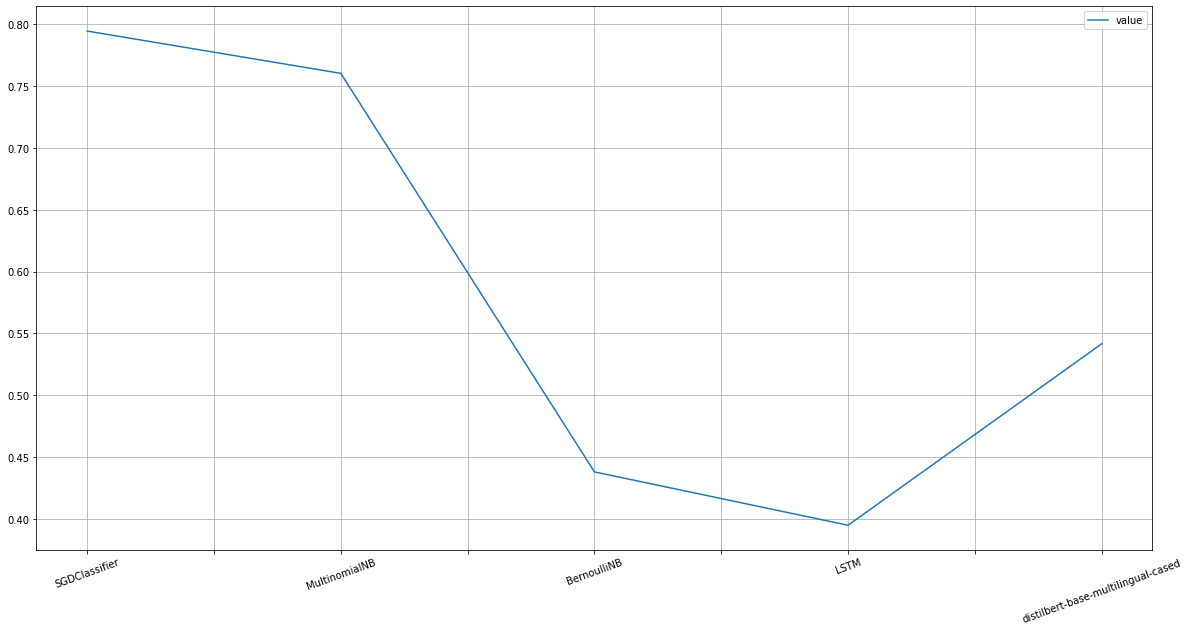

In [ ]:
kf = StratifiedKFold(n_splits=FOLDS)
f_scores = []
model_results = []
for train, test in kf.split(df, y=y):
    df_train = df.iloc[train]
    df_test = df.iloc[test]
    result = train_transformer(df_train, df_test)
    f_scores.append(result.f1_score)
    model_results.append(result)

best_result_index = np.argmax(f_scores)
best_result = model_results[best_result_index]
model_benchmarks[best_result.model_name] = best_result.f1_score
C[best_result.model_name] = best_result.confusion_matrix

plot_benchmarks()

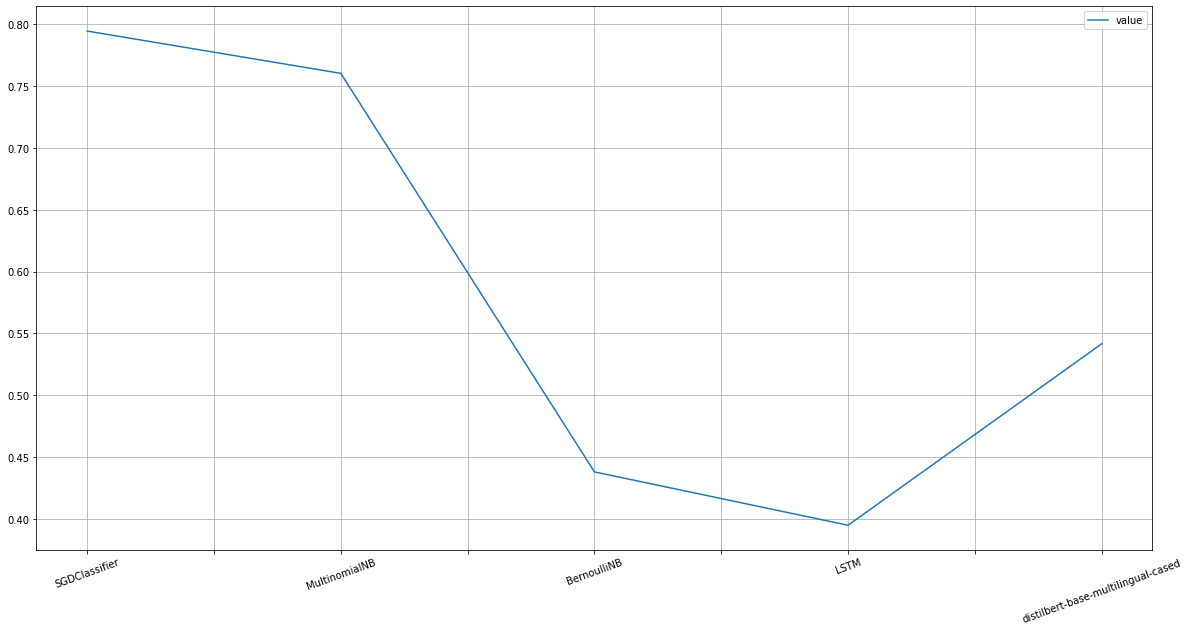

In [ ]:
plot_benchmarks()

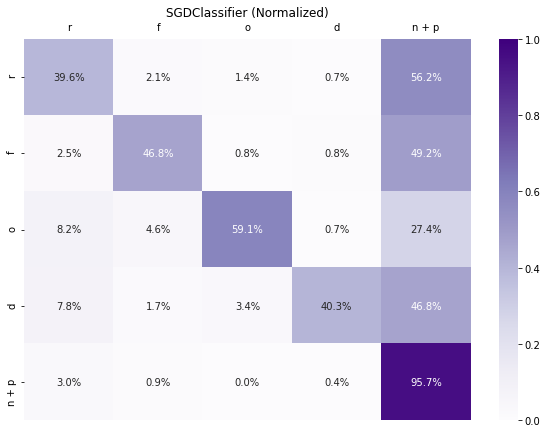

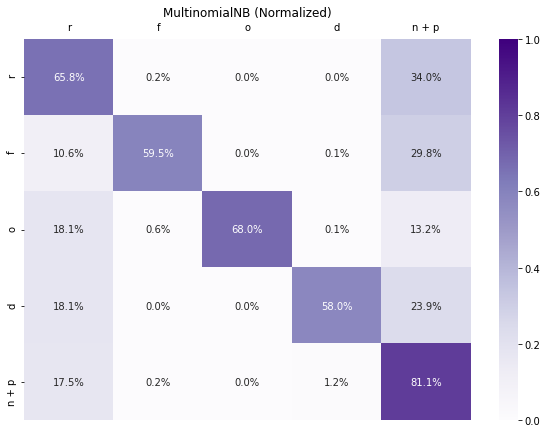

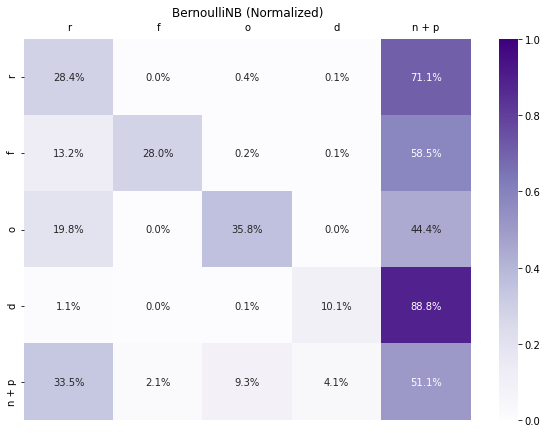

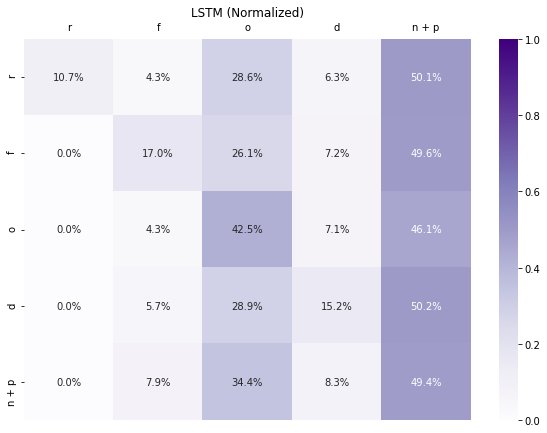

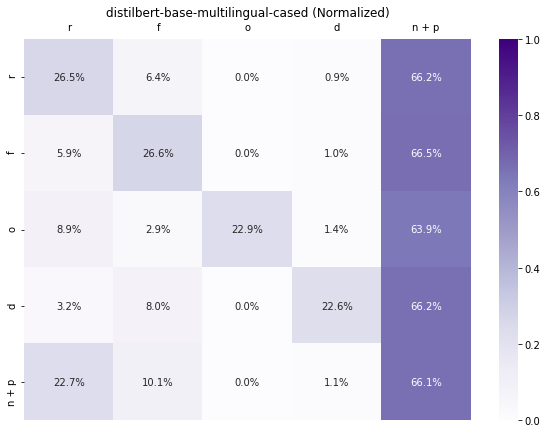

In [ ]:
plot_cms()

In [ ]:
model_benchmarks

{'BernoulliNB': 0.4381747318313231,
 'LSTM': 0.3950961270543916,
 'MultinomialNB': 0.760096930532618,
 'SGDClassifier': 0.7942720763718153,
 'distilbert-base-multilingual-cased': 0.5416724448753854}

In [ ]:
! rm -rf lightning_logs/